In [1]:
import Pkg

Pkg.add("MathOptInterface")
Pkg.add("Ipopt")
Pkg.add("FiniteDiff")
Pkg.add("ForwardDiff")
Pkg.add("Convex")
Pkg.add("ECOS")
Pkg.add("Plots")
Pkg.add("JLD2")
Pkg.add("MeshCat")
Pkg.add("StaticArrays")


Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

    Updating registry at `C:\Users\yuche\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Project.toml`
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Project.toml`
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Project.toml`
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\yuche\OneDrive\D

In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

# Bomb dropper

### Problem statement: 

Toy problem before we add orientation control: let a block with mass $m$ be sliding along $y=0$ under a horizontal force $u$. The block will be attracted by gravity $g$ starting from time $t = T_1$ to hit a the final position $(x, y)$ after some time $T2$. 

# Dynamics function

State:
$$ \mathbf x  = \begin{bmatrix}x& \dot x& y& \dot y\end{bmatrix}^T$$

Dynamics:
$$\dot{\mathbf x} = f(\mathbf x, u) = \begin{cases}
    \begin{bmatrix}\dot x & \frac{u}{m} & \dot y & 0 \end{bmatrix} & t < T_1 \\
    \begin{bmatrix}\dot x & 0 & \dot y & -g \end{bmatrix} & t \ge T_1
\end{cases}$$

In [3]:
# dynamics before release
function dynamics1(params::NamedTuple, x::Vector, u)
    m = params.m
    g = 9.81

    return [
        x[2]; u / m; x[4]; 0 
    ]
end

function dynamics2(params::NamedTuple, x::Vector, u)
    m = params.m
    g = 9.81

    return [
        x[2]; 0; x[4]; -g
    ]
end

function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  

rk4 (generic function with 1 method)

## I formed the following (non linear) optimization problem



   $$ 

% cost function

   \begin{align} 
    \min_{x_{1:N_1 + N_2},u_{1:N_1}, \Delta t_1, \Delta t_2} \quad & J(x_{1:N_1 + N_2},u_{1:N_1}) =  \frac{1}{2} \sum_{i=1}^{N_1} u_i^T R u_i * \Delta t_1& \\ 

% initial condition
 
 \text{st} \quad &  x_1 = x_{ic} & \tag{1}\\

% hit the target at the end

 \quad & x_{N_1 + N_2}[1] = goal_x & \tag{2}\\
 \quad & x_{N_1 + N_2}[3] = goal_y & \tag{3}\\
 
% dynamics constraint during the accelerate phase

&x_{k+1} = f_1(x_k,u_k, \Delta t_1) & \text{for } k =1, \cdots, \mathbf{N_1} \tag{4}\\

% dynamics constraint during the drop phase

&x_{k+1} = f_2(x_k,u_k, \Delta t_2) & \text{for } k =N_1 + 1, \cdots, N_1 + N_2 \tag{5}\\

% range for times

&\Delta t_1 \in [0.01, 0.5]  \tag{6}\\
&\Delta t_2 \in [0.01, 0.5]  \tag{7}\\

 \end{align}$$


In [4]:
# feel free to solve this problem however you like, below is a template for a 
# good way to start. 

function create_idx(nx,nu,N1,N2)
    # create idx for indexing convenience
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    # and stacked dynamics constraints of size nx are 
    # c[idx.c[i]] = <dynamics constraint at time step i>
    #
    # feel free to use/not use this 
    
    # our Z vector is [x0, u0, x1, u1, …, xN1, xN1+1, ... xN2]
    nz = N1 * (nu + nx) + N2 * nx + 2 # length of Z 
    x = vcat([(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N1], [N1 * (nx + nu) + (i - 1) * nx .+ (1 : nx) for i = 1:N2])
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:N1]


    # # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N1 + N2 - 1)]
    nc = (N1 + N2 - 1) * nx # (N-1)*nx 

    T1 = nz - 1
    T2 = nz
    
    return (nx=nx,nu=nu,N1=N1,N2=N2,nz=nz,x=x,u=u,c=c,nc=nc, T1 = T1, T2 = T2)
end


function thrower_cost(params::NamedTuple, Z::Vector)::Real
    # cost function 
    idx, N1 = params.idx, params.N1
    R = params.R
    
    J = 0 
    for i = 1 : N1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        J += 0.5 * ui'*R*ui * (Z[idx.T1] / N1)
    end
        
    return J # + 10 * Z[idx.T] # FIXME: 
end

function thrower_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N1, N2 = params.idx, params.N1, params.N2

    dt1 = Z[idx.T1] / N1
    dt2 = Z[idx.T2] / N2
    
    model = params.model 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    # TODO: input walker dynamics constraints (constraints 3-6 in the opti problem)
    nx = idx.nx

    for i = 1 : N1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        xi1 = Z[idx.x[i+1]]
        c[idx.c[i]] = xi1 - rk4(model, dynamics1, xi, ui, dt1)
    end

    for i = N1+1 : N1 + N2 - 1
        xi = Z[idx.x[i]]
        ui = zeros(idx.nu) # Z[idx.u[i]]
        xi1 = Z[idx.x[i+1]]
        c[idx.c[i]] = xi1 - rk4(model, dynamics2, xi, ui, dt1)
    end

    return c 
end

function thrower_target_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N1, N2 = params.idx, params.N1, params.N2
    target = params.target
    model = params.model 
        
    # create c in a ForwardDiff friendly way (check HW0)
    # c = zeros(eltype(Z), N)
    
    initial_condition_constraint = Z[idx.x[1]] - xic
    terminal_constraint_x = Z[idx.x[N1 + N2][1]] - target[1]
    terminal_constraint_y = Z[idx.x[N1 + N2][3]] - target[2]
    
    return [
        initial_condition_constraint;
        terminal_constraint_x;
        terminal_constraint_y
    ]
end
    
function thrower_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    
    dynamics_constraint = thrower_dynamics_constraints(params, Z)
    target_constraint = thrower_target_constraint(params, Z)

    return [dynamics_constraint; target_constraint]
end

function thrower_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    # idx, N, dt = params.idx, params.N, params.dt
    # M1, M2 = params.M1, params.M2 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), 1)
    
    # TODO: add the length constraints shown in constraints (9-10)
    # there are 2*N constraints here 
    # for i = 1:N
    #     rk_b = Z[idx.x[i]][1:2]
    #     rk_1 = Z[idx.x[i]][3:4]
    #     rk_2 = Z[idx.x[i]][5:6]

    #     c[2 * i - 1] = (rk_b - rk_1)' * (rk_b - rk_1)
    #     c[2 * i] = (rk_b - rk_2)' * (rk_b - rk_2)
    # end

    return c
end

thrower_inequality_constraint (generic function with 1 method)

In [5]:

# dynamics parameters 

# problem size 
nx = 4 
nu = 1

N1 = 20
N2 = 20


m = 1
target = [3, -1]

R = 1.0

model = (
    m=m,
)

xic = [0, 0, 0, 0]

# create indexing utilities 
idx = create_idx(nx,nu,N1, N2)

# put everything useful in params 
params = (
    model = model, 
    nx = nx,
    nu = nu,
    idx = idx,
    N1 = N1,
    N2 = N2,
    target = target,
    R = R,
    xic = xic,
)

(model = (m = 1,), nx = 4, nu = 1, idx = (nx = 4, nu = 1, N1 = 20, N2 = 20, nz = 182, x = UnitRange{Int64}[1:4, 6:9, 11:14, 16:19, 21:24, 26:29, 31:34, 36:39, 41:44, 46:49  …  141:144, 145:148, 149:152, 153:156, 157:160, 161:164, 165:168, 169:172, 173:176, 177:180], u = UnitRange{Int64}[5:5, 10:10, 15:15, 20:20, 25:25, 30:30, 35:35, 40:40, 45:45, 50:50, 55:55, 60:60, 65:65, 70:70, 75:75, 80:80, 85:85, 90:90, 95:95, 100:100], c = UnitRange{Int64}[1:4, 5:8, 9:12, 13:16, 17:20, 21:24, 25:28, 29:32, 33:36, 37:40  …  117:120, 121:124, 125:128, 129:132, 133:136, 137:140, 141:144, 145:148, 149:152, 153:156], nc = 156, T1 = 181, T2 = 182), N1 = 20, N2 = 20, target = [3, -1], R = 1.0, xic = [0, 0, 0, 0])

In [6]:

# TODO: primal bounds (constraint 11)
x_l =  -Inf*ones(idx.nz) # update this 
x_u =  Inf*ones(idx.nz) # update this 

x_l[idx.T1] = 0.1
x_u[idx.T1] = 10

x_l[idx.T2] = 0.1
x_u[idx.T2] = 10


# TODO: inequality constraint bounds
c_l =  -Inf*ones(1) 
c_u =  Inf*ones(1)

# TODO: initialize z0 with the reference Xref, Uref 
z0 = zeros(idx.nz) 
# for k = 1 : N - 1
#     z0[idx.x[k]] = Xref[k]
#     z0[idx.u[k]] = Uref[k]
# end
# z0[idx.x[N]] = Xref[N]

# adding a little noise to the initial guess is a good idea 
z0 = z0 + (1e-6)*randn(idx.nz)
z0[idx.T1] = 1
z0[idx.T2] = 1

diff_type = :auto 

Z = fmincon(thrower_cost,thrower_equality_constraint,thrower_inequality_constraint,
            x_l,x_u,c_l,c_u,z0,params, diff_type;
            tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = true)

# pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:N1 + N2]
U = [Z[idx.u[i]] for i = 1:N1]


---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    29484
Number of nonzeros in inequality constraint Jacobian.:      182
Number of nonzeros in Lagrangian Hessian...

20-element Vector{Vector{Float64}}:
 [11.696683729945356]
 [11.39287339031322]
 [11.089063215850055]
 [10.785253076619316]
 [10.481442887869154]
 [10.177632600001413]
 [9.873822190092111]
 [9.570011654873658]
 [9.266201004993137]
 [8.962390260673182]
 [8.658579448427764]
 [8.354768598949992]
 [8.050957746243913]
 [7.747146927558745]
 [7.4433361842166725]
 [7.139525563576792]
 [6.835715121312629]
 [6.531904924721611]
 [6.228095056539935]
 [5.92428561921222]

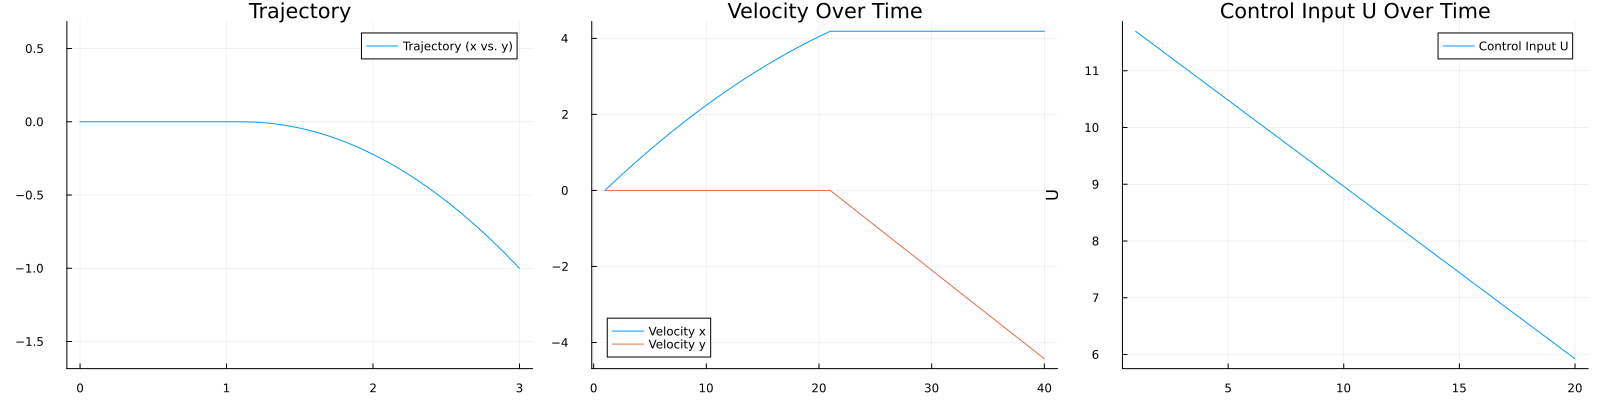

"c:\\Users\\yuche\\OneDrive\\Documents\\0CMU\\academic\\courses\\16-745\\PreciseThrowControl\\bomb_dropper_plot.png"

In [11]:
using Plots


idx_x = 1:(N1)
idx_u = 1:(N1)

# Extracting X and U based on provided indexing scheme
# Adjust according to your actual idx.x and idx.u logic
pos = [[x[1], x[3]] for x in X]  # Positions x, y
vel = [[x[2], x[4]] for x in X]  # Velocities x, y
U = U  # Example control inputs, replace with your actual data extraction

# Plot Trajectory (Position x vs. Position y)
p1 = plot([x[1] for x in pos], [x[2] for x in pos], label="Trajectory (x vs. y)", title="Trajectory", xlabel="Position x", ylabel="Position y", aspect_ratio=:equal)

# Plot Velocities Over Time
p2 = plot(title="Velocity Over Time", xlabel="Time Step")
plot!(p2, [v[1] for v in vel], label="Velocity x")
plot!(p2, [v[2] for v in vel], label="Velocity y")

# # Plot Control Input U Over Time
p3 = plot(idx_u, [u[1] for u in U], label="Control Input U", title="Control Input U Over Time", xlabel="Time Step", ylabel="U")

# Display the plots
display(plot(p1, p2, p3, layout=(1, 3), size=(1600, 400)))
savefig("bomb_dropper_plot.png")



In [23]:
Pkg.add("Measures")
using Measures

   Resolving package versions...
    Updating `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Project.toml`
  [442fdcdd] + Measures v0.3.2
  No Changes to `C:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Manifest.toml`


┌ Info: Saved animation to c:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\trajectory_animation.gif
└ @ Plots C:\Users\yuche\.julia\packages\Plots\Pe7wF\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\yuche\\OneDrive\\Documents\\0CMU\\academic\\courses\\16-745\\PreciseThrowControl\\trajectory_animation.gif")
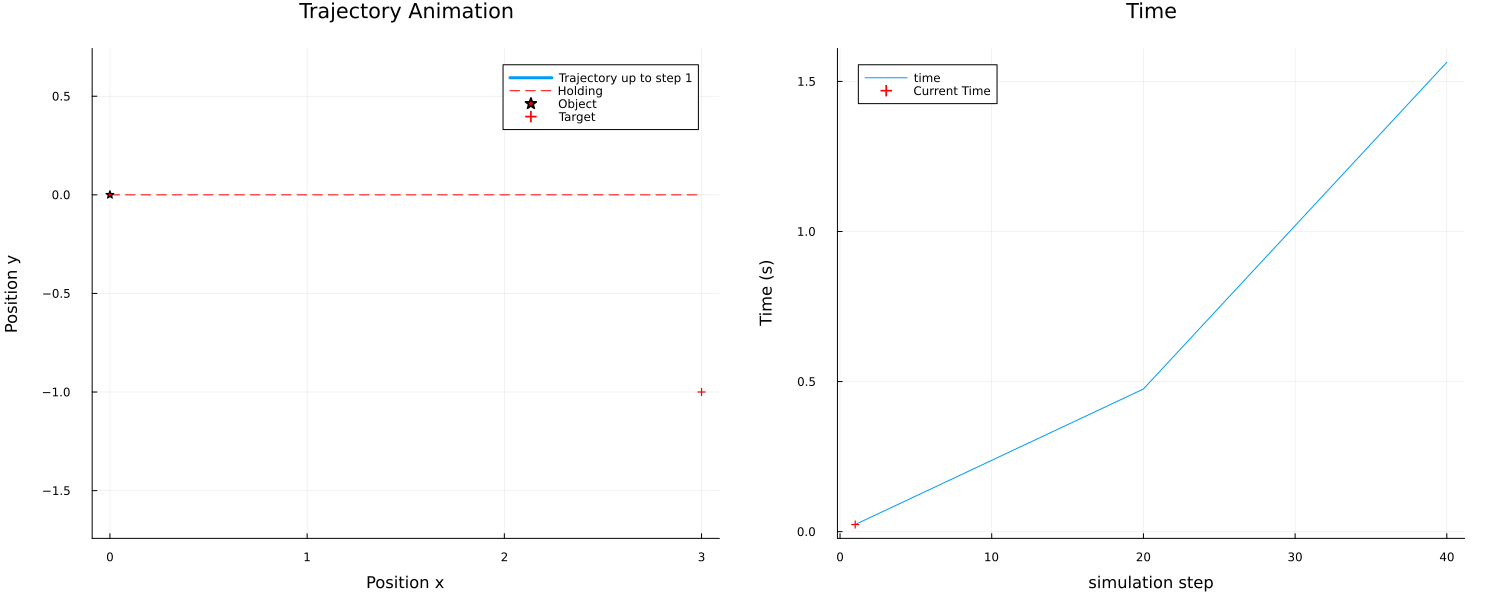

In [27]:
# Animate Trajectory
dt1 = Z[idx.T1] / N1
dt2 = Z[idx.T2] / N2

dt1_array = dt1 * ones(N1)
dt2_array = dt2 * ones(N2)

dt = vcat(dt1_array, dt2_array)
t = cumsum(dt)

anim = @animate for i = 1:length(X)
    plot([x[1] for x in X[1:i]], [x[3] for x in X[1:i]], limit=:auto, label="Trajectory up to step $i", title="Trajectory Animation", xlabel="Position x", ylabel="Position y", aspect_ratio=:equal, linewidth=3)

    if i <= N1
        # holding
        plot!([0, target[1]], [0, 0], label="Holding", color="red", linestyle=:dash)
    else
        # throwing
        plot!([0, target[1]], [0, 0], label="Throwing", color="green", linestyle=:dash)
    end

    scatter!([X[i][1]], [X[i][3]], marker=:star, color="red", label="Object")
    p1 = scatter!([target[1]], [target[2]], marker=:cross, color="red", label="Target")

    plot(t, title="Time", xlabel="simulation step", ylabel="Time (s)", label="time")
    p2 = scatter!([i], [t[i]], marker=:cross, color="red", label="Current Time")

    # concat plots
    p = plot(p1, p2, layout=(1, 2), size=(1500, 600), left_margin=7mm, bottom_margin=7mm, right_margin=7mm, top_margin=7mm)

    savefig(p, "gif/$(i).png")
end

# Save the animation
gif(anim, "trajectory_animation.gif", fps = 5)